<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you:

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should:

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import io
import os
import re
import shutil
import string
import warnings

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Lambda
from tensorflow.keras.layers import TextVectorization, LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow_hub as hub

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [ ]:
link = 'https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv'
data = pd.read_csv(link, encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Preprocessing

In [ ]:
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import en_core_web_md
nlp = en_core_web_md.load()
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
sms_data = data.copy()

# Concaténation des contenus des messages dans une seule colonne
for i in [2, 3, 4]:
  sms_data.loc[sms_data.iloc[:,i].isna() == False,'v2'] += sms_data.loc[sms_data.iloc[:,i].isna() == False,'Unnamed: '+str(i)]

# Renommage des colonnes du dataset
sms_data = sms_data[['v2', 'v1']].rename(columns = {'v2': 'message', 'v1': 'label'})

def is_spam(message):
  if(message=='spam'):
    return 1
  else:
    return 0

# Ajout d'une colonne avec les labels encodés
sms_data["label_encoded"] = sms_data.label.apply(is_spam)

sms_data.head()

,message,label,label_encoded
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [ ]:
# Récupération de 3 spams et 3 hams pour le test
test_indices = [5547, 5566, 5567, 5569, 5570, 5571]
sms_train = sms_data.drop(test_indices)
sms_test = sms_data.iloc[test_indices, :]

print('sms_train :')
display(sms_train)
print()
print('sms_test :')
display(sms_test)

sms_train :


,message,label,label_encoded
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0
...,...,...,...
5562,Ok lor... Sony ericsson salesman... I ask shuh...,ham,0
5563,Ard 6 like dat lor.,ham,0
5564,Why don't you wait 'til at least wednesday to ...,ham,0
5565,Huh y lei...,ham,0



sms_test :


,message,label,label_encoded
5547,Had your contract mobile 11 Mnths? Latest Moto...,spam,1
5566,REMINDER FROM O2: To get 2.50 pounds free call...,spam,1
5567,This is the 2nd time we have tried 2 contact u...,spam,1
5569,"Pity, * was in mood for that. So...any other s...",ham,0
5570,The guy did some bitching but I acted like i'd...,ham,0
5571,Rofl. Its true to its name,ham,0


In [ ]:
xtrain, xval, ytrain, yval = train_test_split(sms_train['message'], sms_train['label_encoded'], test_size=0.3, random_state=0)

In [ ]:
# Construction des datasets tenseurs
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

# Test
xtest = sms_test['message']
ytest = sms_test['label_encoded']
test = tf.data.Dataset.from_tensor_slices((xtest, ytest))

# Construction des batchs
train_batch = train.shuffle(len(train)).batch(512)
val_batch = val.shuffle(len(val)).batch(512)

## Modèle Transfert

In [ ]:
# Import de la couche USE (Universal Sentence Encoder)
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')

model_tr = Sequential([
    # Couche pré-entraînée
    use_layer,
    # Couche de drop-out
    Dropout(0.2),
    # Couche Dense classique
    Dense(64, activation='relu'),
    # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction sigmoid
    Dense(1, activation='sigmoid')
])

model_tr.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
opt3 = tf.keras.optimizers.Adam(name = 'Adam')
bce3 = tf.keras.losses.BinaryCrossentropy()
precision3 = tf.keras.metrics.Precision(name = 'precision')
recall3 = tf.keras.metrics.Recall(name = 'recall')
auc3 = tf.keras.metrics.AUC(name = 'auc')

In [ ]:
model_tr.compile(optimizer=opt3,
                    loss=bce3,
                    metrics=['accuracy',
                             precision3,
                             recall3,
                             auc3])

In [ ]:
history_tr = model_tr.fit(train_batch,
                             epochs=15,
                             validation_data=val_batch)

Epoch 1/15
8/8 [==============================] - 12s 170ms/step - loss: 0.6497 - accuracy: 0.7990 - precision: 0.2871 - recall: 0.3548 - auc: 0.7413 - val_loss: 0.5900 - val_accuracy: 0.8784 - val_precision: 0.9375 - val_recall: 0.1299 - val_auc: 0.9328
Epoch 2/15
8/8 [==============================] - 1s 83ms/step - loss: 0.5510 - accuracy: 0.8842 - precision: 0.9844 - recall: 0.1228 - auc: 0.9054 - val_loss: 0.4973 - val_accuracy: 0.8784 - val_precision: 1.0000 - val_recall: 0.1212 - val_auc: 0.9531
Epoch 3/15
8/8 [==============================] - 1s 84ms/step - loss: 0.4610 - accuracy: 0.8904 - precision: 0.9674 - recall: 0.1735 - auc: 0.9322 - val_loss: 0.4126 - val_accuracy: 0.8946 - val_precision: 1.0000 - val_recall: 0.2381 - val_auc: 0.9633
Epoch 4/15
8/8 [==============================] - 1s 78ms/step - loss: 0.3830 - accuracy: 0.9053 - precision: 0.9737 - recall: 0.2885 - auc: 0.9453 - val_loss: 0.3402 - val_accuracy: 0.9150 - val_precision: 0.9890 - val_recall: 0.3896 - va

53/53 [==============================] - 1s 10ms/step


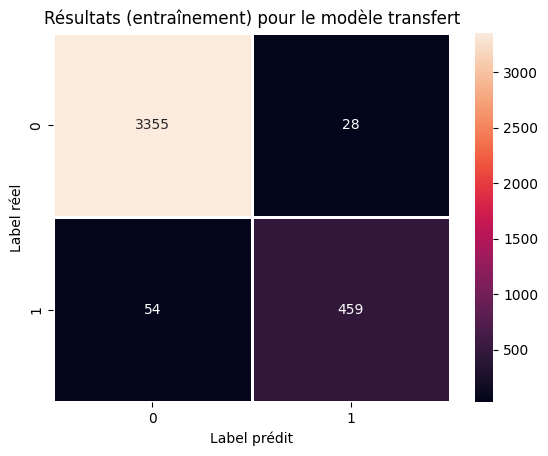

In [ ]:
ypred_train = (model_tr.predict(xtrain) > 0.5).astype("int32")
ypred_val = (model_tr.predict(xval) > 0.5).astype("int32")

mtx = confusion_matrix(ytrain, ypred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('Label réel')
plt.xlabel('Label prédit')
plt.title('Résultats (entraînement) pour le modèle transfert')
plt.show()

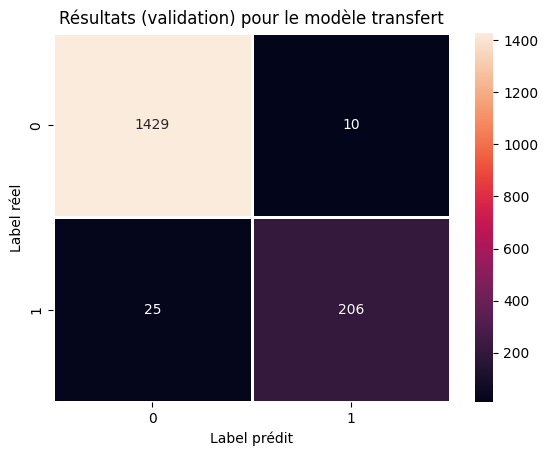

In [ ]:
mtx = confusion_matrix(yval, ypred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('Label réel')
plt.xlabel('Label prédit')
plt.title('Résultats (validation) pour le modèle transfert')
plt.show()

## Evaluation

### Modèle transfert

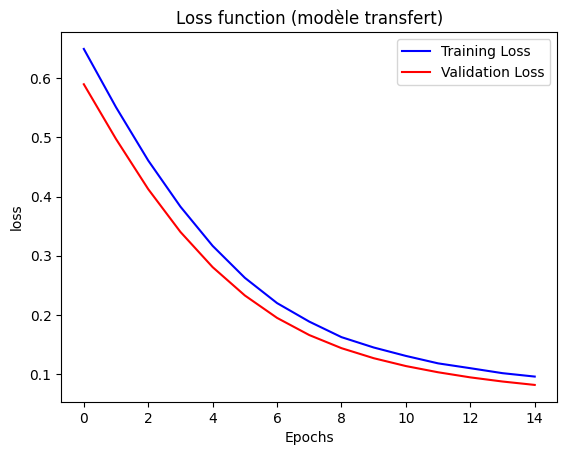

In [ ]:
plt.plot(history_tr.history["loss"], color="b", label="Training Loss")
plt.plot(history_tr.history["val_loss"], color="r", label="Validation Loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title('Loss function (modèle transfert)')
plt.legend()
plt.show()

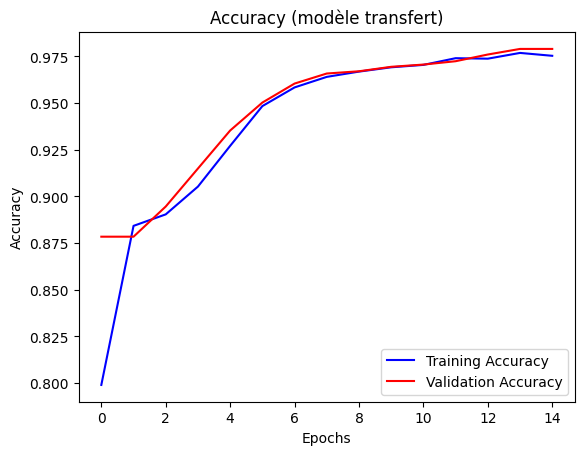

In [ ]:
plt.plot(history_tr.history["accuracy"], color="b", label="Training Accuracy")
plt.plot(history_tr.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title('Accuracy (modèle transfert)')
plt.legend(loc='lower right')
plt.show()

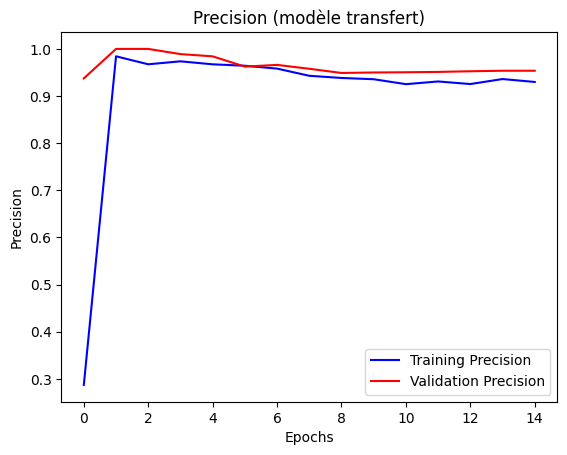

In [ ]:
plt.plot(history_tr.history["precision"], color="b", label="Training Precision")
plt.plot(history_tr.history["val_precision"], color="r", label="Validation Precision")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.title('Precision (modèle transfert)')
plt.legend(loc='lower right')
plt.show()

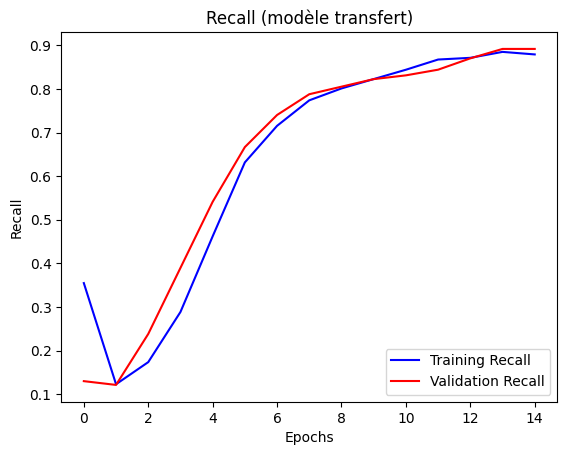

In [ ]:
plt.plot(history_tr.history["recall"], color="b", label="Training Recall")
plt.plot(history_tr.history["val_recall"], color="r", label="Validation Recall")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.title('Recall (modèle transfert)')
plt.legend(loc='lower right')
plt.show()

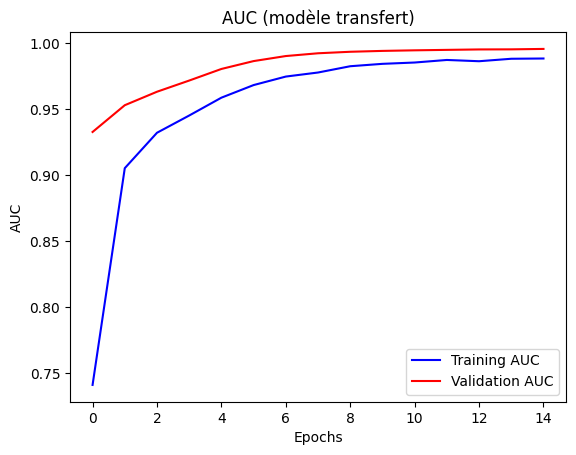

In [ ]:
plt.plot(history_tr.history["auc"], color="b", label="Training AUC")
plt.plot(history_tr.history["val_auc"], color="r", label="Validation AUC")
plt.ylabel("AUC")
plt.xlabel("Epochs")
plt.title('AUC (modèle transfert)')
plt.legend(loc='lower right')
plt.show()

## Prédictions

In [ ]:
ytest

,label_encoded
5547,1
5566,1
5567,1
5569,0
5570,0
5571,0


In [ ]:
# Prédiction avec le modèle transfert
pred = model_tr.predict(xtest)

print("Prédictions sur les messages tests pour le modèle transfert")
for i in range(6):
  pred_value = float(pred[i])
  print(f"Prédiction {i+1} : {pred_value:2.6f} |", f"Vrai label {i+1} : {ytest.iloc[i]}")

1/1 [==============================] - 0s 24ms/step
Prédictions sur les messages tests pour le modèle transfert
Prédiction 1 : 0.885167 | Vrai label 1 : 1
Prédiction 2 : 0.979562 | Vrai label 2 : 1
Prédiction 3 : 0.948354 | Vrai label 3 : 1
Prédiction 4 : 0.036644 | Vrai label 4 : 0
Prédiction 5 : 0.026292 | Vrai label 5 : 0
Prédiction 6 : 0.030588 | Vrai label 6 : 0
